***Prediction of Seattle AirBNB Price in 2016***

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.impute import SimpleImputer
import xgboost as xgb


***1.2. Reading the datasets*** 

In [2]:
df_calander = pd.read_csv ('calendar.csv')

In [3]:
df_calander.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [4]:
df_listing = pd.read_csv('listings.csv')

In [5]:
df_listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


***2.1. Data Cleaning & Visualization***

In [6]:
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

We just consider some important columns for future modeling for df_listing:

In [7]:
df_listing_new = df_listing[['id','room_type', 'accommodates','bathrooms', 'bedrooms', 'beds', 'bed_type'
                             ,'review_scores_rating','review_scores_accuracy', 
                             'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication',
                             'review_scores_location', 'review_scores_value', 'host_since', 'host_response_rate',
                             'host_acceptance_rate', 'host_is_superhost','extra_people' ]]

In [8]:
df_listing_new.isnull().sum()

id                               0
room_type                        0
accommodates                     0
bathrooms                       16
bedrooms                         6
beds                             1
bed_type                         0
review_scores_rating           647
review_scores_accuracy         658
review_scores_cleanliness      653
review_scores_checkin          658
review_scores_communication    651
review_scores_location         655
review_scores_value            656
host_since                       2
host_response_rate             523
host_acceptance_rate           773
host_is_superhost                2
extra_people                     0
dtype: int64

In [9]:
df_calander.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


Finding null values in datasets:

In [10]:
df_calander.isnull().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

In [11]:
df_calander['date'].min()

'2016-01-04'

In [12]:
df_calander['date'].max()

'2017-01-02'

In [13]:
df_calander['date']= pd.to_datetime(df_calander['date'])

In [14]:
df_calander['month']=df_calander['date'].dt.month

I restrict the data to year ='2016' for better comparison.

In [15]:
df_calander_new = df_calander[df_calander['date']<'2017-01-01']

The next step is combining two dataframes on the listing ids. In this way, we can analyze the data easier.

In [16]:
df_combined =  df_calander_new.merge(df_listing_new, left_on='listing_id', right_on='id', how='inner')

In [17]:
df_combined.head()

,listing_id,date,available,price,month,id,room_type,accommodates,bathrooms,bedrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,extra_people
0,241032,2016-01-04,t,$85.00,1,241032,Entire home/apt,4,1.0,1.0,...,10.0,10.0,10.0,9.0,10.0,2011-08-11,96%,100%,f,$5.00
1,241032,2016-01-05,t,$85.00,1,241032,Entire home/apt,4,1.0,1.0,...,10.0,10.0,10.0,9.0,10.0,2011-08-11,96%,100%,f,$5.00
2,241032,2016-01-06,f,NaN,1,241032,Entire home/apt,4,1.0,1.0,...,10.0,10.0,10.0,9.0,10.0,2011-08-11,96%,100%,f,$5.00
3,241032,2016-01-07,f,NaN,1,241032,Entire home/apt,4,1.0,1.0,...,10.0,10.0,10.0,9.0,10.0,2011-08-11,96%,100%,f,$5.00
4,241032,2016-01-08,f,NaN,1,241032,Entire home/apt,4,1.0,1.0,...,10.0,10.0,10.0,9.0,10.0,2011-08-11,96%,100%,f,$5.00


In [18]:
df_combined.drop(['id','available'], axis=1, inplace=True)

In [19]:
df_combined['price'] = df_combined['price'].str.replace('$', '', regex=True)


In [20]:
df_combined['price'] = df_combined['price'].str.replace(',', '')


In [21]:
df_combined['price']=df_combined.price.astype(float)

In [22]:
df_combined['month_label'] = df_combined['month'].apply(lambda x: calendar.month_abbr[x])
df_combined.head()


,listing_id,date,price,month,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,extra_people,month_label
0,241032,2016-01-04,85.0,1,Entire home/apt,4,1.0,1.0,1.0,Real Bed,...,10.0,10.0,9.0,10.0,2011-08-11,96%,100%,f,$5.00,Jan
1,241032,2016-01-05,85.0,1,Entire home/apt,4,1.0,1.0,1.0,Real Bed,...,10.0,10.0,9.0,10.0,2011-08-11,96%,100%,f,$5.00,Jan
2,241032,2016-01-06,NaN,1,Entire home/apt,4,1.0,1.0,1.0,Real Bed,...,10.0,10.0,9.0,10.0,2011-08-11,96%,100%,f,$5.00,Jan
3,241032,2016-01-07,NaN,1,Entire home/apt,4,1.0,1.0,1.0,Real Bed,...,10.0,10.0,9.0,10.0,2011-08-11,96%,100%,f,$5.00,Jan
4,241032,2016-01-08,NaN,1,Entire home/apt,4,1.0,1.0,1.0,Real Bed,...,10.0,10.0,9.0,10.0,2011-08-11,96%,100%,f,$5.00,Jan


One question to answer is average per month to see if there are some correlation between season and price.

In [23]:
df_agg_monthly_price = (df_combined
                        .groupby(['month_label'])
                        .price
                        .agg(['mean'])
                        .rename({'mean': 'average_price_per_day'}, axis=1)
                        .reset_index()
                       )

df_agg_monthly_price

,month_label,average_price_per_day
0,Apr,135.097005
1,Aug,150.656594
2,Dec,137.251835
3,Feb,124.293927
4,Jan,121.568409
5,Jul,152.094150
6,Jun,147.473137
7,Mar,128.644488
8,May,139.538183
9,Nov,135.688738


In [24]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

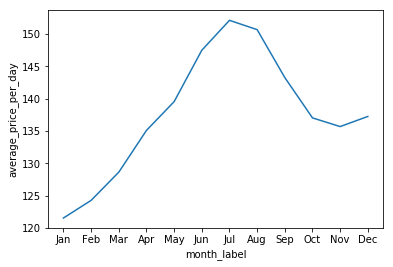

In [25]:
df_agg_monthly_price['month_label'] = pd.Categorical(df_agg_monthly_price['month_label'],
                                   categories=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
                                   ordered=True)


sns.lineplot(
    data=df_agg_monthly_price,
    x="month_label", y="average_price_per_day")

As you see here, the maximum average price per day is seen at June, July and August.

The lowest price was in January.

In [26]:
df_combined['host_is_superhost'] = df_combined['host_is_superhost'].map({'f':0 , 't':1})

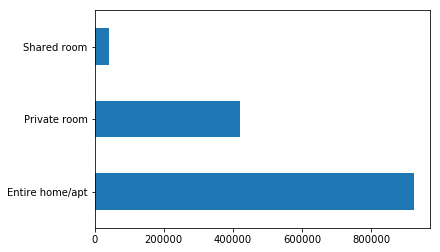

In [27]:
df_combined['room_type'].value_counts().plot(kind='barh');

As you see above, most of the requests were for entire home vs room.

/Users/mashtari/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


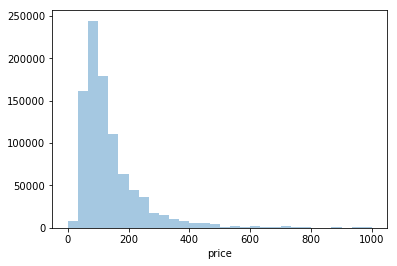

In [28]:
bins = np.linspace(0,1000,31)
g = sns.distplot(df_combined['price'], kde= False, bins=bins)


As you see here most of the listings price were below 200$ per night.

Now, we start to figureout null values in the dataframe. The review scores were replaced by median values. For number of bedrooms, bathrooms, .. the mode was used.

In [29]:
reviews = ['review_scores_rating',
           'review_scores_accuracy', 'review_scores_cleanliness',
           'review_scores_checkin', 'review_scores_communication',
           'review_scores_location', 'review_scores_value']
for review in reviews:
    df_combined[review].fillna(df_combined[review].median(),inplace=True)

In [30]:
room_features = ['accommodates', 'bathrooms', 'bedrooms', 'beds']
for feature in room_features:
    df_combined[feature].fillna(df_combined[feature].mode()[0],inplace=True)

In [31]:
other_features = ['host_response_rate','host_acceptance_rate']
for feature in other_features:
    df_combined[feature].fillna(df_combined[feature].mode()[0],inplace=True)

As There were some null prices, to avoid inserting bias in the predictions, the rows with null prices were removed.

In [32]:
df_final = df_combined[df_combined['price'].notnull()]

In [33]:
df_final['host_acceptance_rate'].value_counts()

100%    928481
0%         363
Name: host_acceptance_rate, dtype: int64

In [34]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 928844 entries, 0 to 1385579
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   listing_id                   928844 non-null  int64         
 1   date                         928844 non-null  datetime64[ns]
 2   price                        928844 non-null  float64       
 3   month                        928844 non-null  int64         
 4   room_type                    928844 non-null  object        
 5   accommodates                 928844 non-null  int64         
 6   bathrooms                    928844 non-null  float64       
 7   bedrooms                     928844 non-null  float64       
 8   beds                         928844 non-null  float64       
 9   bed_type                     928844 non-null  object        
 10  review_scores_rating         928844 non-null  float64       
 11  review_scores_accuracy   

There are still some cleaning work to do. So, the 'extra people' column was modified.

In [35]:
df_final['extra_people'] = df_final['extra_people'].str.replace('$', '', regex=True)

<ipython-input-35-1e99df71f7f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['extra_people'] = df_final['extra_people'].str.replace('$', '', regex=True)


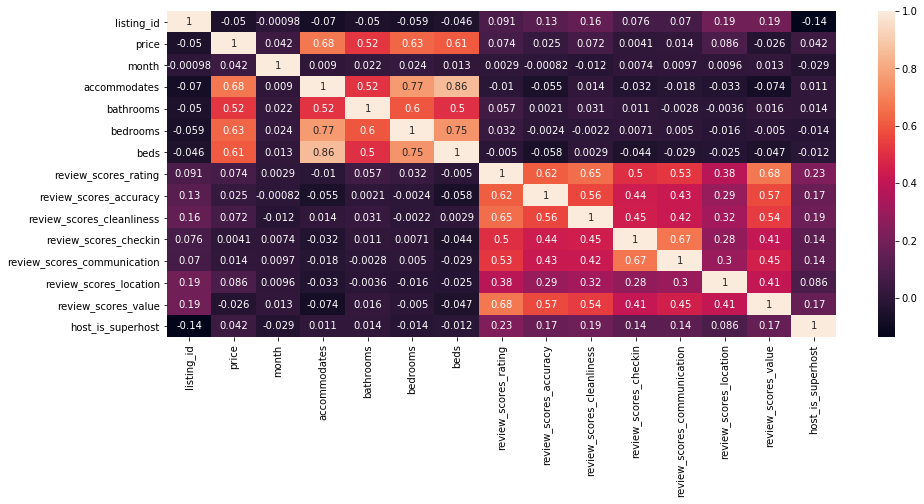

In [36]:
fig , ax = plt.subplots(figsize=(15, 6), nrows=1, ncols=1)


Var_Corr = df_final.corr()
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)


This heatmap make it clear that price is more correlated with number of accomodates, bathrooms,bedrooms and beds. Being superhost is also important for reviews.

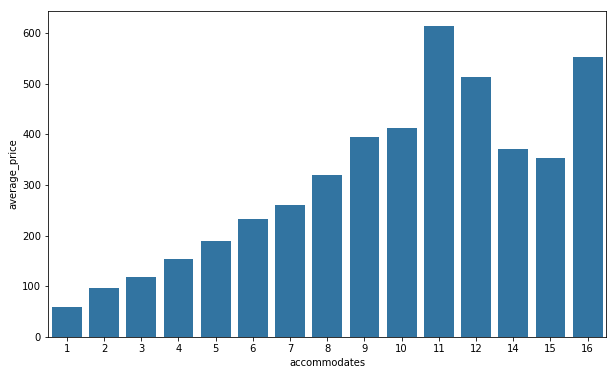

In [37]:
df_agg_accommodate = (df_final
                      .groupby(['accommodates'])
                      .agg({'price':'mean'})
                      .rename({'price': 'average_price'}, axis=1)
                      .reset_index()
                     )
fig, ax = plt.subplots(figsize=(10,6), nrows=1, ncols=1)

sns.barplot(x="accommodates", y="average_price", color=sns.color_palette('tab20',10)[0],
            data=df_agg_accommodate, ax=ax);

In most of the cases, higher number of accommodates correlates with higher average prices.

In [38]:
# take the year that hosting started.
df_final['host_since'] = pd.to_datetime(df_final['host_since']).dt.year


<ipython-input-38-6876058f686d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['host_since'] = pd.to_datetime(df_final['host_since']).dt.year


In [39]:
df_final.columns

Index(['listing_id', 'date', 'price', 'month', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'host_since',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'extra_people', 'month_label'],
      dtype='object')

This heatmap make it clear that price is more correlated with number of accomodates, bathrooms,bedrooms and beds. Being superhost is also important for reviews.

Then, we start to explore categorical columns:

In [40]:
df_final.columns[df_final.dtypes == object]

Index(['room_type', 'bed_type', 'host_response_rate', 'host_acceptance_rate',
       'extra_people', 'month_label'],
      dtype='object')

In [41]:
df_final['extra_people'] = df_final['extra_people'].astype(float)


<ipython-input-41-6eb118e082b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['extra_people'] = df_final['extra_people'].astype(float)


In [42]:
df_final.loc[:,'extra_people_fee'] = np.where(df_final['extra_people']>0, 1, 0)
 
    

/Users/mashtari/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/mashtari/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [43]:
df_final.drop(['extra_people', 'date', 'month_label', 'listing_id'], axis=1, inplace=True)


/Users/mashtari/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [44]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 928844 entries, 0 to 1385579
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   price                        928844 non-null  float64
 1   month                        928844 non-null  int64  
 2   room_type                    928844 non-null  object 
 3   accommodates                 928844 non-null  int64  
 4   bathrooms                    928844 non-null  float64
 5   bedrooms                     928844 non-null  float64
 6   beds                         928844 non-null  float64
 7   bed_type                     928844 non-null  object 
 8   review_scores_rating         928844 non-null  float64
 9   review_scores_accuracy       928844 non-null  float64
 10  review_scores_cleanliness    928844 non-null  float64
 11  review_scores_checkin        928844 non-null  float64
 12  review_scores_communication  928844 non-null  float64
 13

In [45]:
df_final.head()

,price,month,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,extra_people_fee
0,85.0,1,Entire home/apt,4,1.0,1.0,1.0,Real Bed,95.0,10.0,10.0,10.0,10.0,9.0,10.0,2011.0,96%,100%,0.0,1
1,85.0,1,Entire home/apt,4,1.0,1.0,1.0,Real Bed,95.0,10.0,10.0,10.0,10.0,9.0,10.0,2011.0,96%,100%,0.0,1
9,85.0,1,Entire home/apt,4,1.0,1.0,1.0,Real Bed,95.0,10.0,10.0,10.0,10.0,9.0,10.0,2011.0,96%,100%,0.0,1
10,85.0,1,Entire home/apt,4,1.0,1.0,1.0,Real Bed,95.0,10.0,10.0,10.0,10.0,9.0,10.0,2011.0,96%,100%,0.0,1
14,85.0,1,Entire home/apt,4,1.0,1.0,1.0,Real Bed,95.0,10.0,10.0,10.0,10.0,9.0,10.0,2011.0,96%,100%,0.0,1


Categorical columns converted to dummies to be able to use machine learning models.

***3. Data Modeling***

In [46]:
categorical_cols = df_final.columns[df_final.dtypes == object].tolist()
categorical_cols

['room_type', 'bed_type', 'host_response_rate', 'host_acceptance_rate']

In [47]:
for col in categorical_cols:
    df_final = pd.concat([df_final.drop(col, axis=1), pd.get_dummies(df_final[col], prefix=col, prefix_sep='_',
                                                               drop_first=True, dummy_na=True)], axis=1)

In [48]:
df_final.drop(['host_response_rate_nan','host_acceptance_rate_nan'], axis=1, inplace=True)

In [49]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [50]:
df_clean = clean_dataset(df_final)

In [51]:
df_clean.head(2)

,price,month,accommodates,bathrooms,bedrooms,beds,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,...,host_response_rate_91%,host_response_rate_92%,host_response_rate_93%,host_response_rate_94%,host_response_rate_95%,host_response_rate_96%,host_response_rate_97%,host_response_rate_98%,host_response_rate_99%,host_acceptance_rate_100%
0,85.0,1.0,4.0,1.0,1.0,1.0,95.0,10.0,10.0,10.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,85.0,1.0,4.0,1.0,1.0,1.0,95.0,10.0,10.0,10.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [52]:
X = df_clean.drop(['price'],axis=1)
y = df_clean['price']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=42)

At first, I used random forest model. 

In [54]:
RF = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=42, 
                               n_jobs=-1)
RF.fit(X_train, y_train.squeeze())

RandomForestRegressor(n_jobs=-1, random_state=42)

In [55]:
y_train_preds = RF.predict(X_train)
y_test_preds = RF.predict(X_test)

In [56]:
  mean_squared_error(y_train, y_train_preds), mean_squared_error(y_test, y_test_preds)

(400.5818910612156, 424.1234218815883)

In [57]:
 r2_score(y_train, y_train_preds), r2_score(y_test, y_test_preds)

(0.9638396644844197, 0.9612678783184695)

The r2 score was around 0.96 which is high.

Which features were more important in determinig the price?


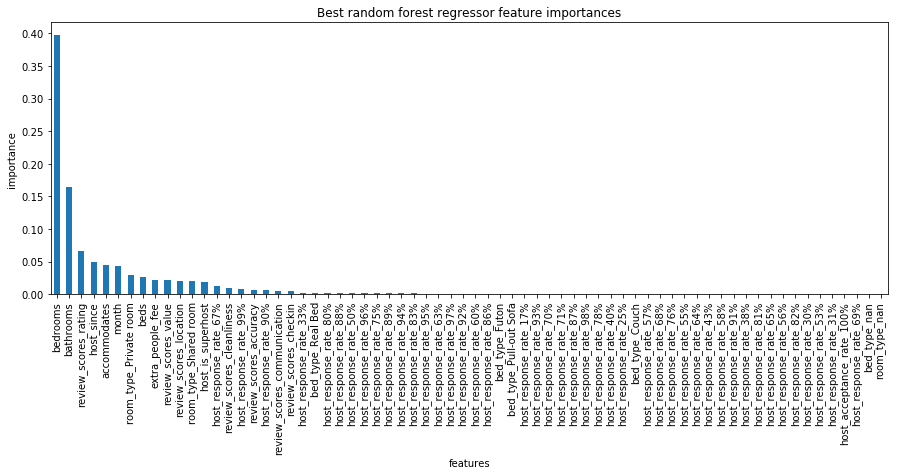

In [58]:
plt.subplots(figsize=(15, 5))
imps = RF.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('random forest regressor feature importances');

As you see, the most important features were, number of bedrooms and bathrooms and reveiw score ratings.

Then, we try XGBoost model for comparison.

In [62]:
xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, max_depth=7)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [63]:
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

In [64]:
 mean_squared_error(y_train, y_train_preds),mean_squared_error(y_test, y_test_preds)

(1741.0435994263034, 1746.1582274490888)

In [65]:
 r2_score(y_train, y_train_preds),r2_score(y_test, y_test_preds)

(0.8428368278562848, 0.8405360103888673)

It seems random forest had better performance interms of mean squared error and r2 score.

***4. Evaluation & Correlation***

* As you see above random forest model was much better than XGBoost in terms of mean squared error and r2 score.
Now Here is the final conclusions:

1)The maximum average price per day is seen at June, July and August and minimum average price is seen on January and November.

2)Most of the posting were entire home/apartments.

3)The listing prices in most of the cases were below 200 dollars. Most of the cases were around 100 dollars per night. There were very few cases around $1000 per night.

4) The price was increasing with number of accomodates untill 11 accomodates. After 11 accomodates, the price was not increasing with number of accomodates.

5)Based on the heatmap, price was correlating with number of accomodates, bedrooms, bathrooms and beds.Reveiw_scores parameters were correlating with host being superhost or not.

6) The final feature importance on random forest model showed that five most important features were number of bedrooms, bathrooms, reveiw_scores_rating and the length of the time the person was host as well as number of accomodates.

